## SB-GRU-RNN + Hyperparameter GridSearch - Base Model Titik Panas

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# # Install depedency -> scikeras
# !pip install scikeras

In [ ]:
# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd
import random as rm
import time as tm

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
# # Setting Algorithm
# algorithm = "LSTM-RNN"

In [ ]:
# Setting Algorithm
algorithm = "GRU-RNN"

### 1. Akuisisi Data

In [ ]:
# Set waktu komputasi
start = tm.time()

In [ ]:
# Import from Drive
dataset = pd.read_csv("/content/drive/MyDrive/BOPTN_2024/dataset/dataset_hotspot.csv", parse_dates=["acq_date"])

# Import from Local
# dataset = pd.read_csv("dataset/dataset_hotspot.csv", parse_dates=["acq_date"])

In [ ]:
# Show information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.4 KB


In [ ]:
# Show dataset
print(dataset)

      acq_date  hotspot
0   2001-01-31        3
1   2001-02-28        5
2   2001-03-31       10
3   2001-04-30       20
4   2001-05-31       39
..         ...      ...
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42

[276 rows x 2 columns]


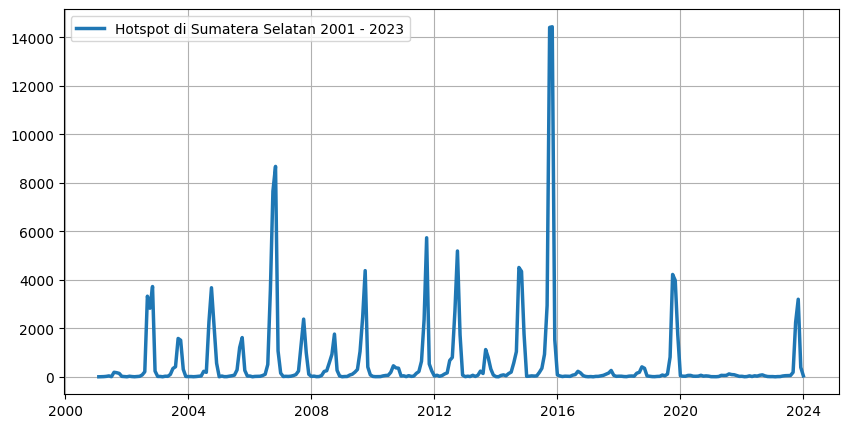

In [ ]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 2. PraProses Data

- seleksi fitur

In [ ]:
# hanya memperhatikan aspek hotspot
data = dataset.filter(["hotspot"])
data = data.values

In [ ]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]])

In [ ]:
# cek dimensi normalisasi
data.shape

(276, 1)

- Normalisasi Data

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(np.array(data))

In [ ]:
# cek dimensi normalisasi
scaled.shape

(276, 1)

- Hasil PraProses Data

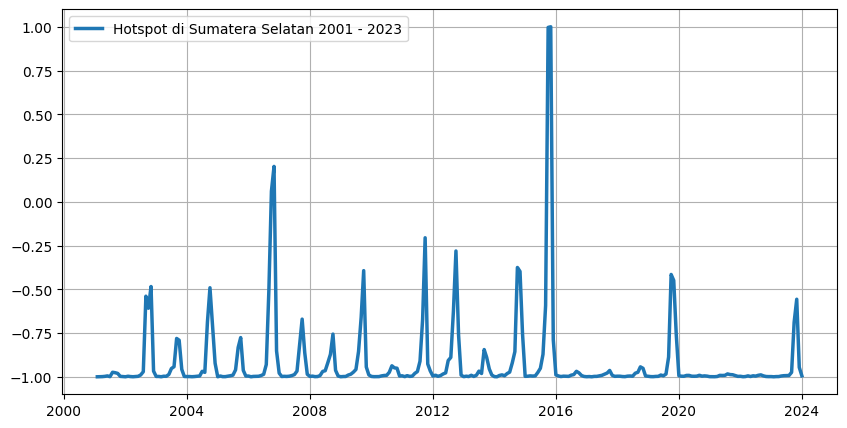

In [ ]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], np.array(scaled), color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 3. Pembagian Data

In [ ]:
# data train = tahun 2001 - 2018 = 216
# data test = tahun 2019 - 2023 = 60

In [ ]:
# data train
train_size = 216

# set loc data train
train_data = scaled[0:train_size,:]

# show data train
np.round(train_data[:5],7)

array([[-1.       ],
       [-0.9997229],
       [-0.9990301],
       [-0.9976445],
       [-0.9950118]])

In [ ]:
# view dimension of data train
train_data.shape

(216, 1)

In [ ]:
# data test
test_size = 60

# set loc data test
test_data = scaled[train_size:len(scaled),:]

# show data test
np.round(test_data[:5],7)


array([[-0.9990301],
       [-0.9993072],
       [-0.9979216],
       [-0.9975059],
       [-0.9900236]])

In [ ]:
# view dimension of data test
test_data.shape

(60, 1)

- cek hasil pembagian data

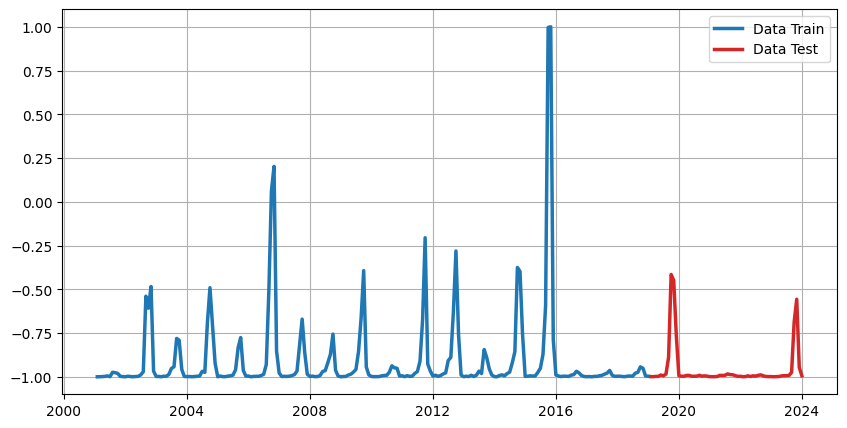

In [ ]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:len(train_data),0], train_data, color="tab:blue", label="Data Train", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data):len(dataset),0], test_data, color="tab:red", label="Data Test", linewidth=2.5)

# make are labels
# ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
# ax.set_xlabel("Years", fontsize=12)
# ax.set_ylabel("Sum of hotspot", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 5. Supervised Learning

In [ ]:
# function for supervised learning
def create_dataset(look_back, dataset):

    # declare variable X and Y
    dataX = []
    dataY = []

    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):

        # insert value X and Y
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])

    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [ ]:
# set time series lag
look_back = 1

In [ ]:
# Proses supervised learning
x_train, y_train = create_dataset(look_back, train_data)
print(x_train.shape, y_train.shape)

(215, 1) (215,)


In [ ]:
# Proses supervised learning
x_test, y_test = create_dataset(look_back, test_data)
print(x_test.shape, y_test.shape)

(59, 1) (59,)


In [ ]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

- hasil supervised learning

In [ ]:
# cek dimensi data
print(x_train.shape, x_test.shape)

(215, 1, 1) (59, 1, 1)


### 6. Hyperparameter GridSearchCV GRU-RNN

In [ ]:
# Install depedency -> scikeras
!pip install scikeras

In [ ]:
from itertools import product
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# function models
def get_model(activation='selu', optimizer='sgd', dropout_rate=0.15):

    # reset of session model
    tf.keras.backend.clear_session()

    # design network
    model = Sequential()

    # # Jika menggunakan SB-LSTM-RNN
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=True), input_shape=(x_train.shape[1], 1)))
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=True)))
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    # the output layer
    model.add(Dense(1))

    # compiling model
    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError(),
        ]
    )

    # return value
    return model

In [ ]:
# Creating KerasRegressor wrapper for GridSearchCV
grid_model = KerasRegressor(model=get_model, verbose=1)

In [ ]:
# Set param for GridSearch [1]
param_grid = {
    'model__activation': ['relu', 'selu', 'elu', 'softplus'],
    'model__optimizer': ['adam', 'adamax', 'rmsprop', 'sgd'],
    'model__dropout_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'batch_size': [2, 4, 8, 16, 32],
    'epochs': [1500],
}

In [ ]:
param_grid

{'model__activation': ['relu', 'selu', 'elu', 'softplus'],
 'model__optimizer': ['adam', 'adamax', 'rmsprop', 'sgd'],
 'model__dropout_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
 'batch_size': [2, 4, 8, 16, 32],
 'epochs': [1500]}

In [ ]:
# Menghitung jumlah kombinasi
total_combinations = len(list(product(*param_grid.values())))
print("Total kombinasi:", total_combinations)

Total kombinasi: 400


In [ ]:
# process a gridsearchCV
grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=10, scoring='neg_root_mean_squared_error')

In [ ]:
# process a gridsearchCV
grid_result = grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 400 candidates, totalling 800 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/1500
54/54 [==============================] - 6s 3ms/step - loss: 0.5594 - mean_absolute_error: 0.5594 - mean_squared_error: 0.3730 - mean_absolute_percentage_error: 61.8511
Epoch 2/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1388 - mean_absolute_error: 0.1388 - mean_squared_error: 0.0695 - mean_absolute_percentage_error: 27.5960
Epoch 3/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1256 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0733 - mean_absolute_percentage_error: 27.1081
Epoch 4/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1218 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0707 - mean_absolute_percentage_error: 26.9988
Epoch 5/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1137 - mean_absolute_error: 0.1137 - mean_squared_error: 0.0679 - mean_absolute_percentage_error: 26.0984
Epoch 6/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1085 - mean_ab

In [ ]:
# summarize results
print("Best parameters: %f using %s\n" % (grid_search.best_score_, grid_search.best_params_))

Best parameters: -0.198060 using {'batch_size': 4, 'epochs': 1500, 'model__activation': 'selu', 'model__dropout_rate': 0.25, 'model__optimizer': 'sgd'}



In [ ]:
# # Specify the text file name
# csv_file = '/content/drive/MyDrive/BOPTN_2024/best_params_best_model_gru.csv'

# create dataframe from best_param
df = pd.DataFrame([grid_search.best_params_])

# write csv form dataframe
csv_file = "M3_best_param.csv"
df.to_csv(csv_file, index=False)

In [ ]:
# show the results
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.225964 (0.063481) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.05, 'model__optimizer': 'adam'}
-0.371617 (0.208889) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.05, 'model__optimizer': 'adamax'}
-0.256109 (0.034315) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.05, 'model__optimizer': 'rmsprop'}
-0.241738 (0.036030) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.05, 'model__optimizer': 'sgd'}
-0.224128 (0.048739) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.1, 'model__optimizer': 'adam'}
-0.213155 (0.044266) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0.1, 'model__optimizer': 'adamax'}
-0.239708 (0.052853) with: {'batch_size': 2, 'epochs': 1500, 'model__activation': 'relu', 'model__dropout_rate': 0

In [ ]:
# show the results
result = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["score"])],axis=1)

In [ ]:
# show the results
result.sort_values(by="score", ascending=False)

,batch_size,epochs,model__activation,model__dropout_rate,model__optimizer,score
119,4,1500,selu,0.25,sgd,-0.198060
111,4,1500,selu,0.15,sgd,-0.198954
195,8,1500,selu,0.20,sgd,-0.198964
172,8,1500,relu,0.20,adam,-0.198985
199,8,1500,selu,0.25,sgd,-0.199503
...,...,...,...,...,...,...
89,4,1500,relu,0.15,adamax,-0.694439
324,32,1500,relu,0.10,adam,-0.703248
240,16,1500,relu,0.05,adam,-0.888197
160,8,1500,relu,0.05,adam,-1.187340


In [ ]:
# Save the result to csv
result_base_model_gru = pd.DataFrame(result.sort_values(by="score", ascending=False))
result_base_model_gru_file = f'/content/drive/MyDrive/BOPTN_2024/result_base_model_gru.csv'
with open(result_base_model_gru_file, mode='w') as f:
  result_base_model_gru.to_csv(f)

### 7. Evaluasi Model

In [ ]:
# Set akhir waktu komputasi
end = tm.time()

In [ ]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [ ]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

02:54:54.37
